# Lab 10/Mini-Project 2: Exploring magnetic ordering using neutron diffraction

*Antiferromagnetism* is the phenomenon where alternate magnetic moments in a solid point in opposite directions. As a result, the solid has no magnetic moment, making this behaviour a little tricky to observe directly. (This contrasts with *ferromagnetism*, the familiar phenomenon in iron where each magnetic moment has the same direction, and therefore the solid as a whole acts as a magnet.) However, antiferromagnetism increases (often, doubles) the crystallographic unit cell size for radiation beams sensitive to magnetism, such as neutrons. As a result, characteristic peaks are produced in a neutron diffraction pattern.

This ordering typically only happens at very low temperatures, where thermal energy does not disrupt the order. Important parameters that characterise this behaviour include the *transition temperature* below which the magnetic moments order and the *critical exponent* that describes how rapidly they order.

In this mini-project, we will determine these parameters directly from neutron diffraction data collected at ISIS, the UK’s national neutron source, using the integration and curve-fitting skills from recent labs. Among the first materials to have an antiferromagnetic neutron diffraction pattern measured was manganese(II) oxide, MnO (see references below. The material from which these data were collected is also a manganese(II) compound, methylammonium manganese(II) formate (CH<sub>3</sub>NH<sub>3</sub>Mn(HCO<sub>2</sub>)<sub>3</sub>) [[1](http://dx.doi.org/10.1039/C6TC03992H)].

## 1. Loading and plotting the data

You are provided with eight data sets named `data_TTTTT.txt`, where `TTTTT` represents the temperature at which the data were collected. In each data set, the first column is “$d$-spacing”, a common quantity in crystallography, measured in angstrom ($1\,\mathrm{Å}=10^{-10}\,\mathrm{m}$). (You may remember Bragg’s law, $\lambda = 2d\sin\theta$; this is the same $d$, so that it is inversely proportional to the angle $\theta$ through which the neutrons were scattered.) The second column is the diffracted intensity $I$. I have selected only the portion of the diffraction pattern that is due to magnetic scattering. 

Use the `loadtxt` command from `numpy` to **load each of these data sets. Plot them on the same axes.** (*Hint*: the `loadtxt` command will have loaded the data sets into a $N\times2$ `array`, so you will want to plot `whatever[:,0]` on the $x$ axis and `whatever[:,1]` on the $y$ axis.)

You should see that there is definitely a magnetic phase transition somewhere in the range of temperatures for which we have collected data!

In [39]:
from matplotlib.pylab import figure, plot, grid, legend, xlabel, ylabel, title, subplots
%matplotlib notebook
import numpy as np
import warnings

<IPython.core.display.Javascript object>


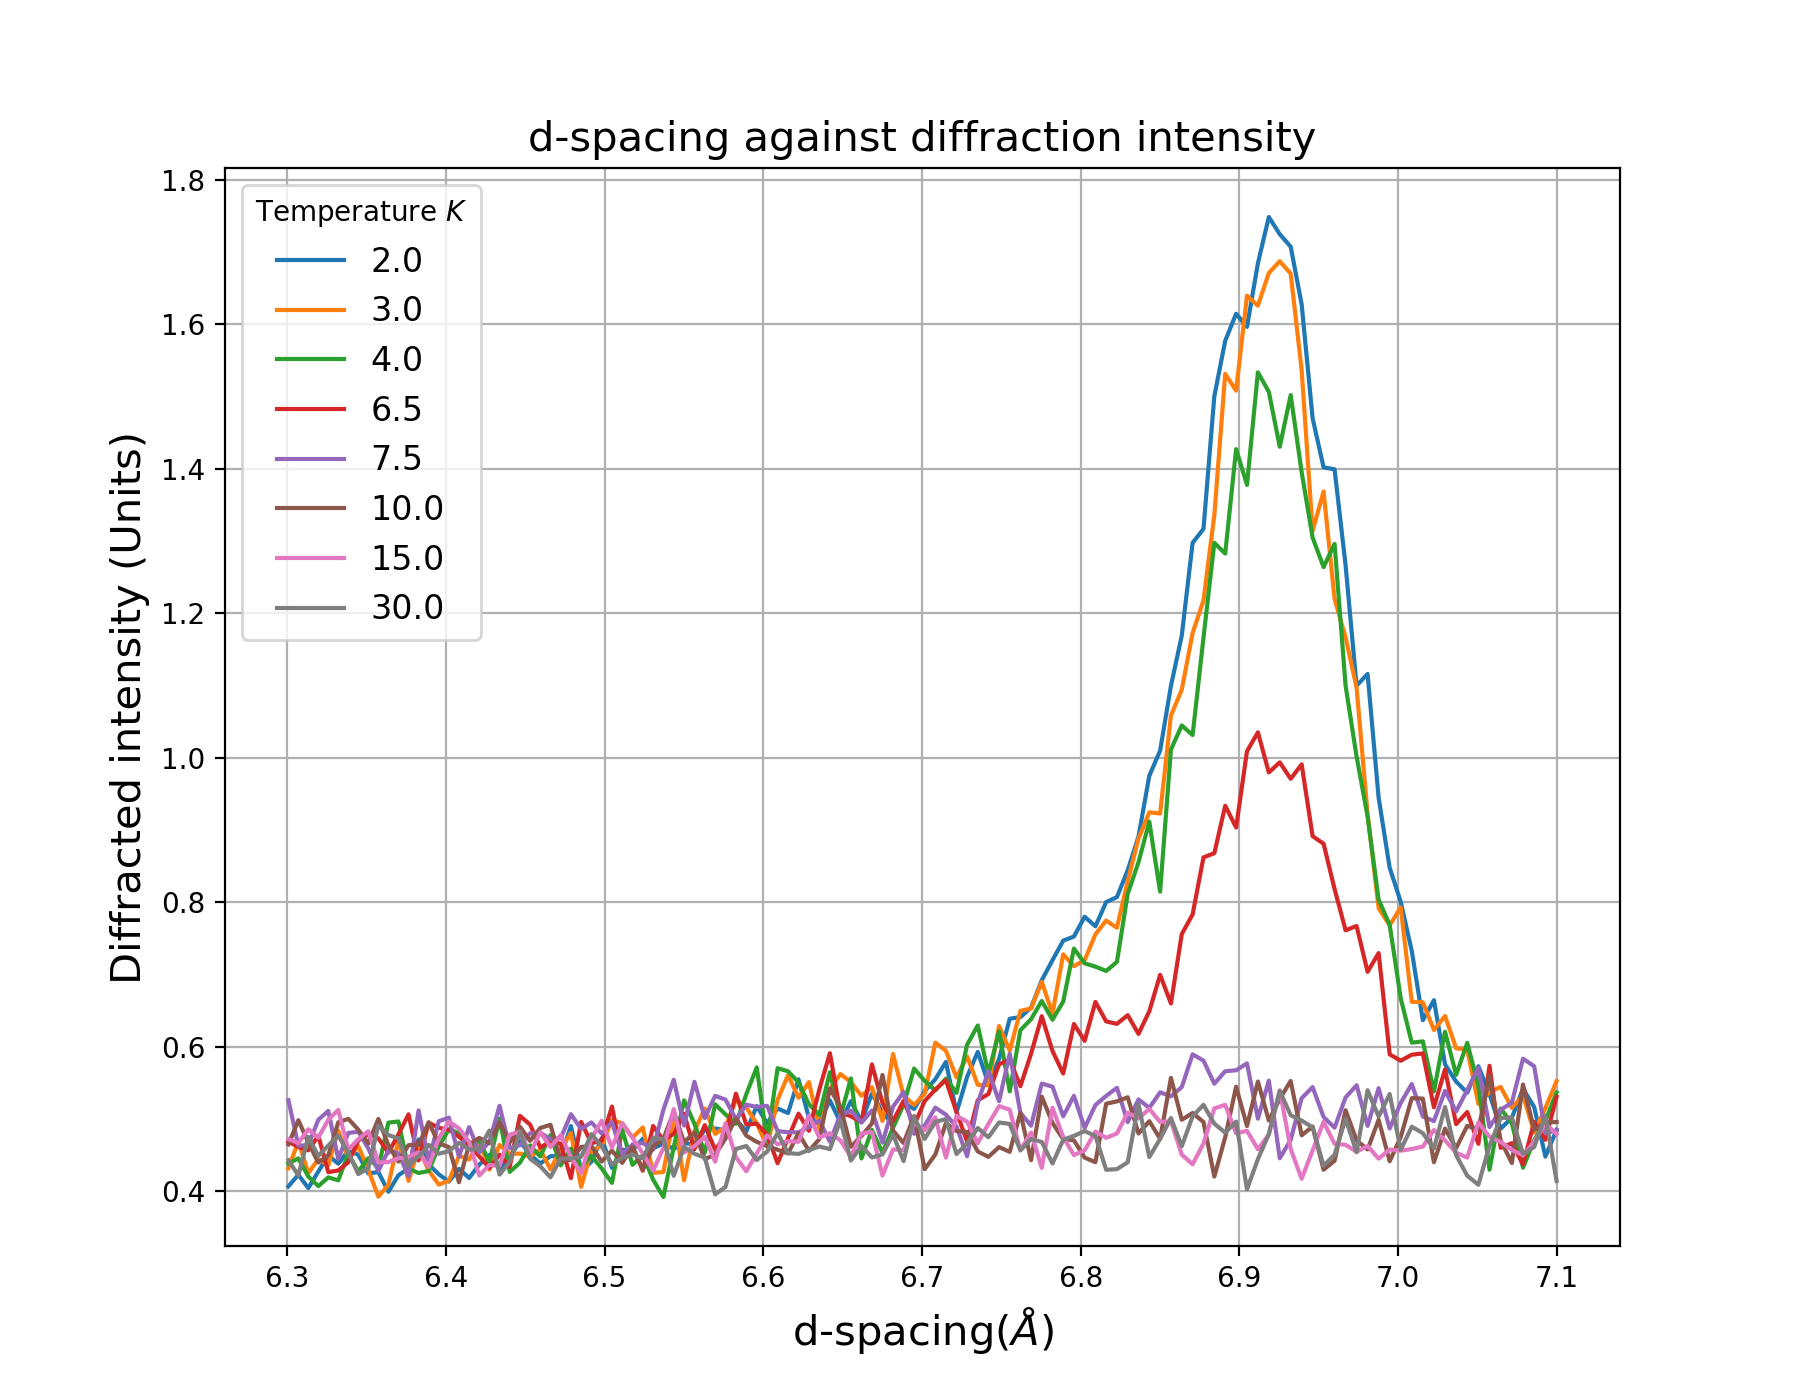

In [3]:
temperatures = "02.0,03.0,04.0,06.5,07.5,10.0,15.0,30.0".split(",")

data = {}

def data_importer_and_plotter(x):
    figure(figsize=(9,7))
    for i in x:
        import_data = np.loadtxt("project2_data/data_{}K.txt".format(i))
        data["data{}K".format(i)] = import_data
        plot(import_data[:,0],import_data[:,1],label=float(i))
    xlabel("d-spacing($\AA$)",fontsize="15")
    ylabel("Diffracted intensity (Units)",fontsize="15")
    title("d-spacing against diffraction intensity",fontsize="15")
    grid()
    legend(title="Temperature $K$",prop={'size':12},loc="upper left")

data_importer_and_plotter(temperatures)

## 2. Integrating the data

You will see that the steps in $d$-spacing are not even, due to the particular experimental setup we used. As a result, the `trapezoid` function we have previously coded is not appropriate. However, we can still use the trapezoid method.

If you are feeling brave, code this yourself. (*Hint*: since the spacing along the $d$-axis is not constant, you will need to consider all of the $d$ values rather than just a single value of the spacing as we did in class.)

If you are not feeling so brave, use the `trapz` function from `numpy` to do this for you.

Either way, **integrate the data and plot the integrated magnetic diffraction intensity as a function of temperature.**

<IPython.core.display.Javascript object>


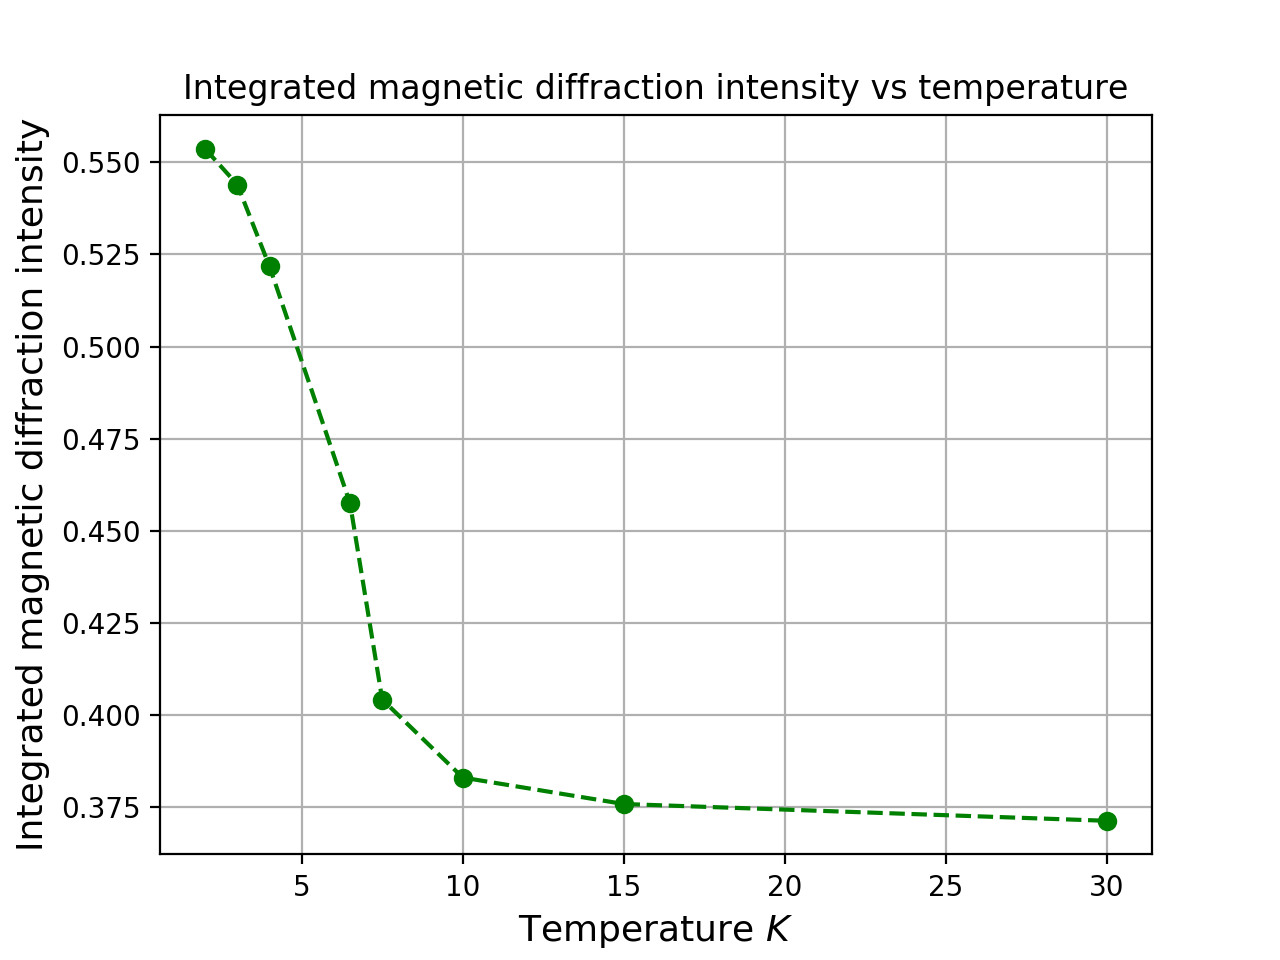

In [4]:
integrated_data = []

def integrator(data):
    for i in data:
        integral_data = np.trapz(data[i][:,1],data[i][:,0])
        integrated_data.append(integral_data)
        
integrator(data)

float_temp = [float(i) for i in temperatures]

figure()
ylabel("Integrated magnetic diffraction intensity",fontsize="13")
xlabel("Temperature $K$",fontsize="13")
title("Integrated magnetic diffraction intensity vs temperature")
grid()
plot(float_temp,integrated_data,"--go")

## 3. A model for the magnetic signal as a function of temperature

The usual functional form to which we fit these data is

$$
M(T) = \begin{cases}A(T_0 - T)^\beta + B & T < T_0 \\ B & T \geq T_0\end{cases}.
$$

You can see that this gives the magnetisation $M$ as a function of temperature $T$ with four parameters: the amplitude $A$ of the magnetic signal, the magnetic transition temperature $T_0$, the *critical exponent* $\beta$, and a constant background $B$.

**Code this function in Python.** (*Hint*: you will want this to work with `array`s `T`. So rather than saying

    if T < T0:
        ...
        
as you might if you were considering only a single value of `T`, use the `where` function from `numpy`. This has syntax

    where(condition, value_if_true, value_if_false)
    
so you might write

    where(T < T0, ..., ...)
    
which will work beautifully with `array`s.)

**Find suitable initial guesses for $A$, $T_0$, $\beta$, and $B$.** This is a fairly fiddly function to fit, and you will need these initial guesses to be pretty close for the fitting routine that follows to work!

<IPython.core.display.Javascript object>


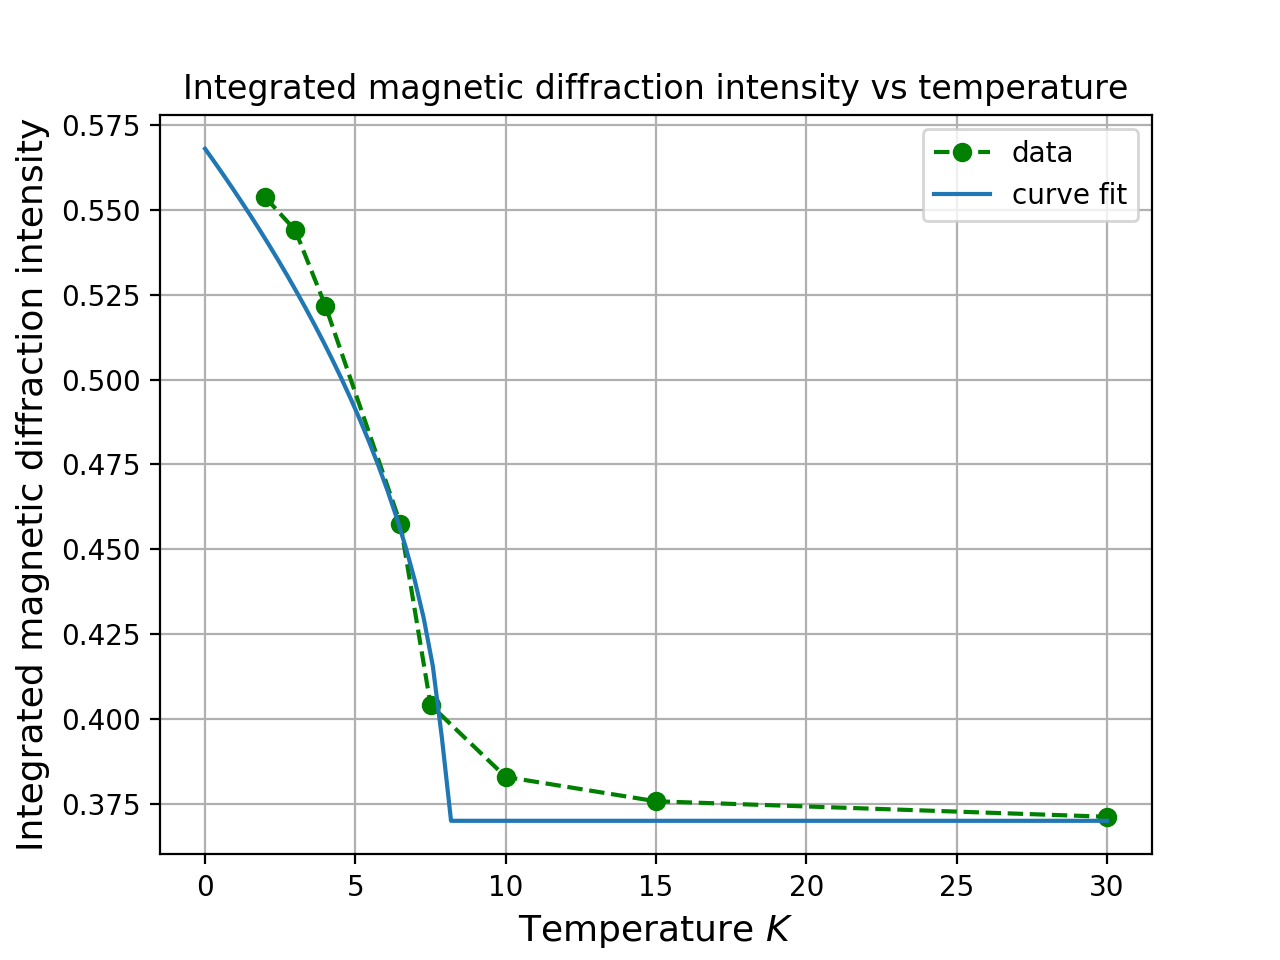

In [6]:
def M(T,parameters):
    A, T0, ß, B = parameters
    T = np.array(T)
    T0 = np.array(T0)
    return np.where(T < T0,A*((T0-T)**ß) + B, B)

x = np.linspace(0,30,100)
yfit = M(x,(0.07,8,0.5,0.37))

figure()
ylabel("Integrated magnetic diffraction intensity",fontsize="13")
xlabel("Temperature $K$",fontsize="13")
title("Integrated magnetic diffraction intensity vs temperature")
grid()
plot(float_temp,integrated_data,"--go",label="data") 
plot(x,yfit,label="curve fit")
legend()

warnings.filterwarnings('ignore')

## 4. Fitting the data

**Fit the model to the data.** One way of doing this is to use the code that we developed in Lab 9. You will need to define a suitable function `g`; the remaining functions `CD`, `jacobian`, and `nD_Newton_step` should be able to be used essentially unchanged. Of course you may want to experiment with changing them!

An alternative method, once again, is to use the built-in fitting functions. If you want to explore these I recommend starting with `curve_fit`, from the `scipy.optimize` module.

**Plot your fit and check it looks sensible.** What is the magnetic transition temperature? What is the critical exponent $\beta$? What would you expect the intensity of the magnetic peak to be at 0 K?

In [7]:
def g(parameters,data):
    """Represents the vector function g derived from a model for magnetic signal for nonlinear least-squares fitting."""
    A, T0, ß, B = parameters
    T, y = data
    T = np.array(T)
    y = np.array(y)
    g1 = np.sum((M(T,parameters) - y)*np.where(T < T0,((T0-T)**ß),0))
    g2 = np.sum((M(T,parameters) - y)*np.where(T < T0,(A*ß*((T0-T)**ß-1)),0))
    g3 = np.sum((M(T,parameters) - y)*np.where(T < T0,(A*((T0-T)**ß)*np.log(T0-T)),0))
    g4 = np.sum((M(T,parameters) - y))
    return g1,g2,g3,g4
                
def CD(f, x0, h):
    """Returns the derivative of f at x0 evaluated using the central difference algorithm with step size h."""
    return (f(x0 + h/2) - f(x0 - h/2))/np.linalg.norm(h)

def jacobian(g, parameters, data):
    """Returns the Jacobian matrix of g evaluated at param, given observed data."""
    p = np.array(parameters)
    delta = 1e-6
    N = len(parameters)
    
    # Start with an empty matrix of the right size.
    jac = np.zeros((N,N))

    # We want to calculate df_i/dp_j for all i and j, so need two loops.
    for i in range(N):
        # Define an appropriate one-dimensional function f_i:
        def g_i(x):
            return g(x,data)[i]
        for j in range(N):
            # Set up a step of delta in the appropriate direction:
            dv = np.zeros(N)
            dv[j] = delta
            
            jac[i,j] = CD(g_i, p, dv)
            
    return jac

def nD_Newton_step(g, p, data):
    return p - np.linalg.solve(jacobian(g,p,data),g(p,data))

In [8]:
p0 = 0.07,8,0.5,0.37 #original paramets from function. 
p1 = 0.1,8,0.5,0.37 #changing A
p2 = 0.07,6.8,0.5,0.37 # changing T0
p3 = 0.07,8,0.7,0.37 # changing ß

param_list = p0, p1, p2, p3

def parameter_finder(p_list):
    Curve_fit_paramaters = []
    for i in p_list:
        eps = 1e-7
        converged = False
        while not converged:
            p = nD_Newton_step(g, i, (float_temp,integrated_data))
            if np.linalg.norm(p - i) < eps:
                converged = True
                params = p
            else:
                i = p
        Curve_fit_paramaters.append(params)
    return Curve_fit_paramaters
        
standard_data = parameter_finder(param_list)
warnings.filterwarnings('ignore')

<IPython.core.display.Javascript object>


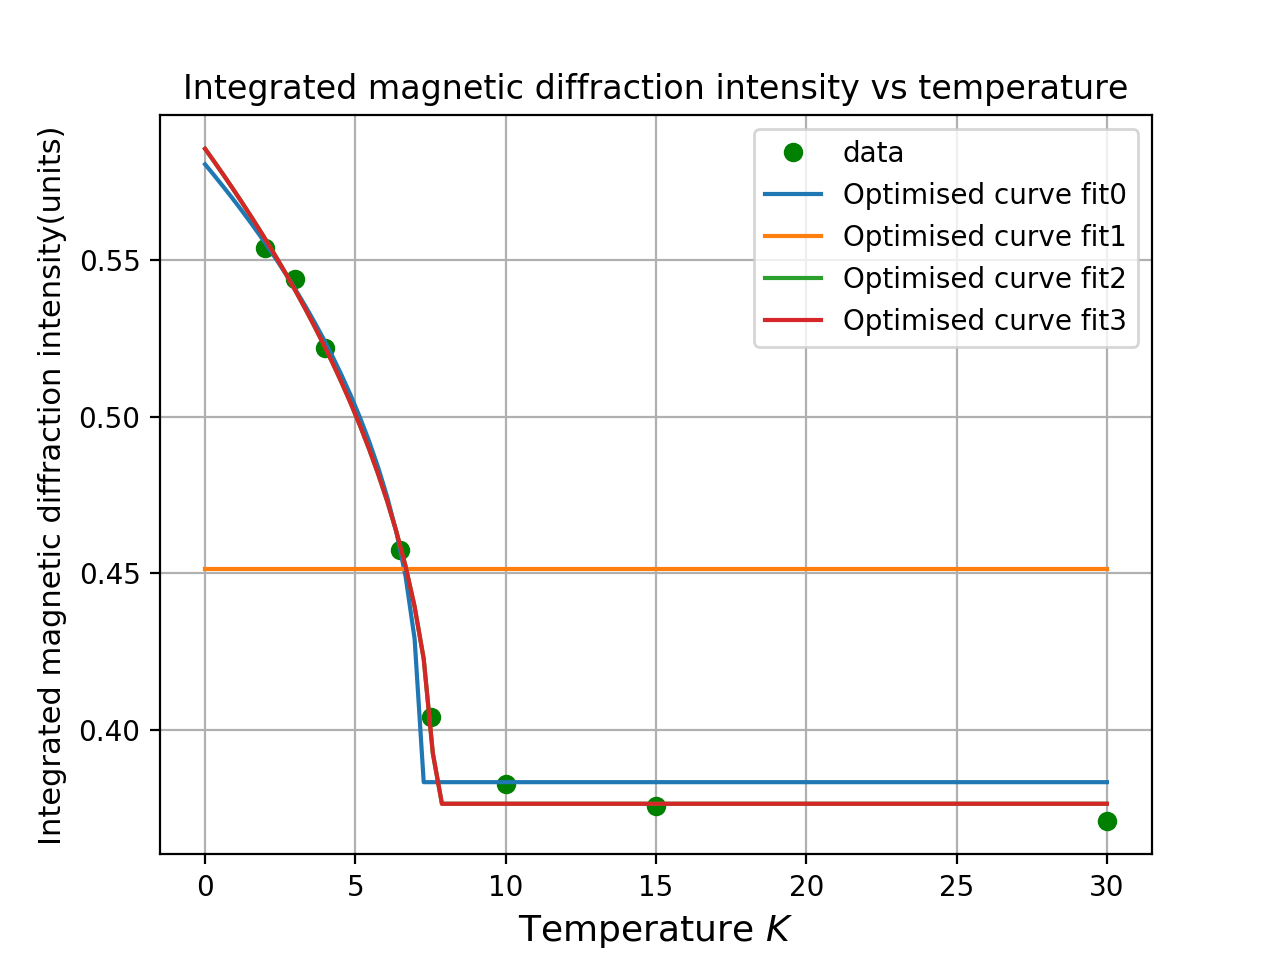

In [10]:
def curve_fitter(p,title1="Integrated magnetic diffraction intensity vs temperature"):
    figure()
    ylabel("Integrated magnetic diffraction intensity(units)",fontsize="11")
    xlabel("Temperature $K$",fontsize="13")
    title(title1)
    grid()
    plot(float_temp,integrated_data,"go",label="data")
    count = -1
    for i in p:
        count += 1
        plot(x,M(x,i),label="Optimised curve fit{}".format(count))
    legend()

curve_fitter(standard_data)
warnings.filterwarnings('ignore')

<IPython.core.display.Javascript object>


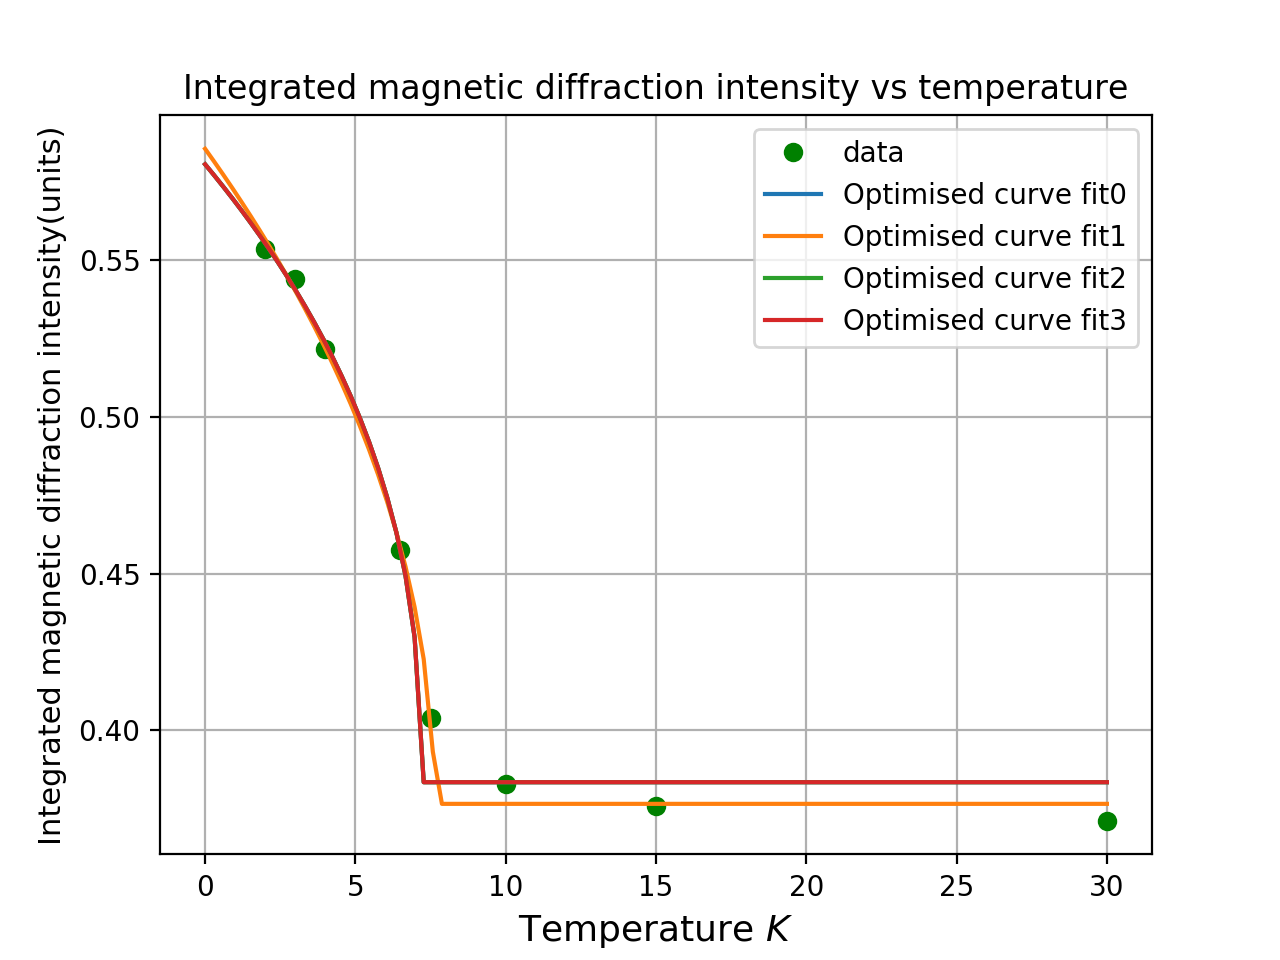

In [11]:
from scipy.optimize import curve_fit

def Redefined_M(T, A, T0, ß, B): #because scipy is dumb.
    T = np.array(T)
    T0 = np.array(T0)
    return np.where(T < T0,A*((T0-T)**ß) + B, B)

def scipy_paramater_finder(p,data):
    x, y = data
    scipy_paramaters = []
    for m in p:
        parameters = curve_fit(Redefined_M,x,y,m)[0]
        scipy_paramaters.append(parameters)
    return scipy_paramaters
        
scipy_calculated_data = scipy_paramater_finder(param_list,(float_temp,integrated_data))
                       
curve_fitter(scipy_calculated_data)
warnings.filterwarnings('ignore')

## 5. Discussion and further exploration

Explore your model. Some questions you might want to consider: how sensitive is your fit to the initial guess? Can you come up with a different plausible fit? What happens if you change the integration range? How sensitive is the fit to noise in the data? What happens if you delete just one point: does the fit change much?

Of course feel free to come up with your own questions about the model you have built!

### Why curve fit is better than our own defined algorithm.

In our case the curve_fit uses the Levenberg-Marquardt algorithm (LMA) since we give no bounds to the parameters. The "trf" and "dogbox", the other two method that can be specified to the curve_fit function, are meant to work better when bounds are given however if no bounds are given then they will return a similar fit to LMA. The LMA interpolates between the Gauss–Newton algorithm (GNA) (what we use) and the method of gradient descent. The gradient descent method which is where the alogrithm takes a step proportional to the negative of the gradient so that it find a minimum or a step proportional to the positive of a gradient to find the maximum. This is what allows the LMA to be less sensitive to initial paramaters compared to the function we defined. This is becuase it can use the gradient descent to find the solution even if it starts far off the final minimum. A clear example is observed when looking at the fits generated by our function where one of the fits is just a straight line but the curve_fit manages to fit well all of the fits since it use the gradient descent method to get closer to a minima making it easier for it to find optimal parameters to fit the data to, unlike the GNA.

In [67]:
# How much faster curve_fit is compared to what we made.

%timeit scipy_paramater_finder(param_list,(float_temp,integrated_data))
%timeit parameter_finder(param_list)

#clearly ALOT faster.

2.29 ms ± 178 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
147 ms ± 3.62 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


### How sensitive is the fit to noise in the data?

<IPython.core.display.Javascript object>


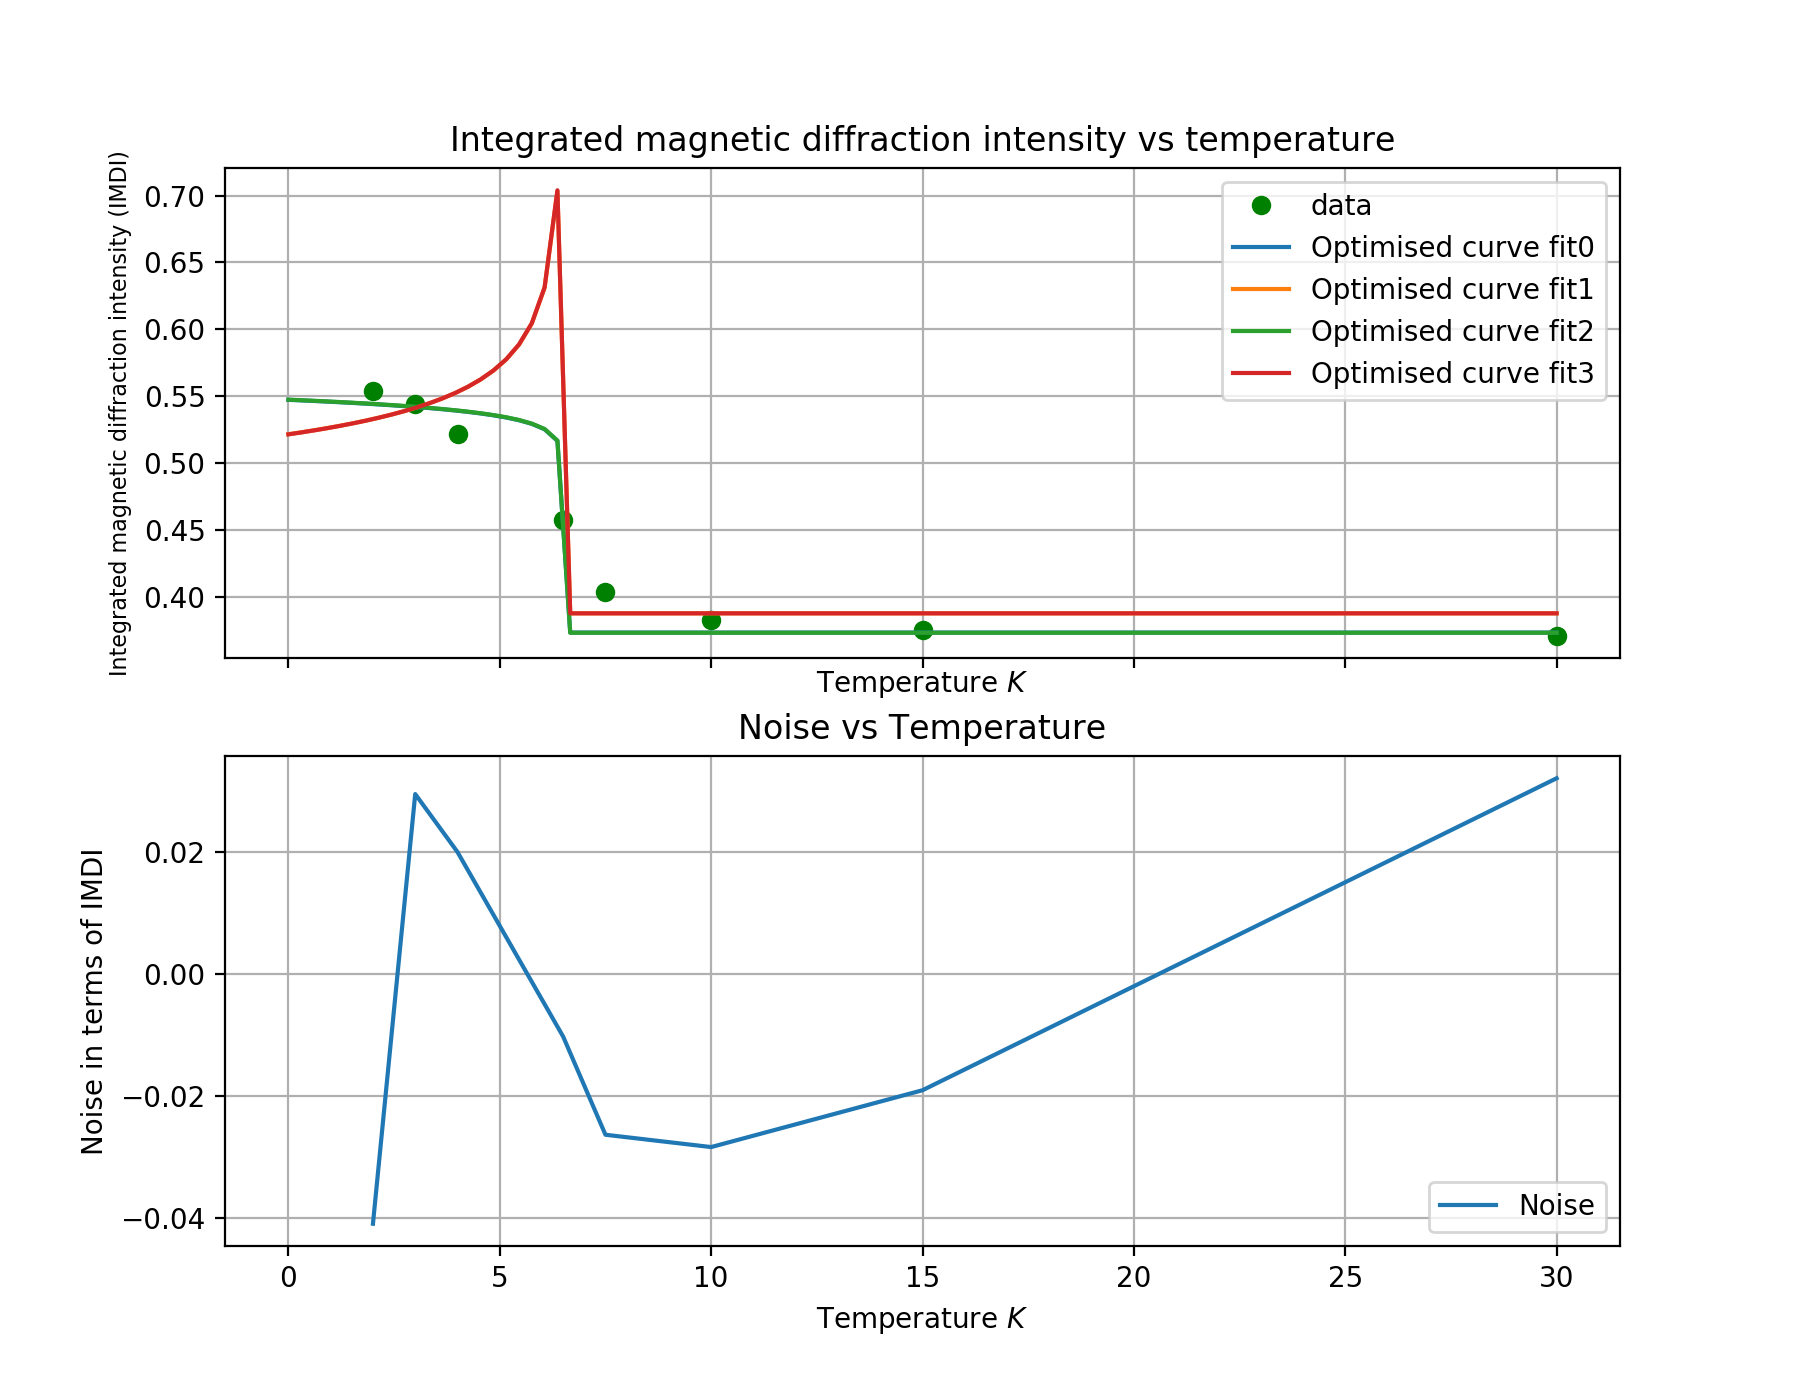

In [42]:
noise = np.random.uniform(-0.05,0.05,len(integrated_data))
noisy_integrated_data = integrated_data + noise

noisy_data = scipy_paramater_finder(param_list,(float_temp,noisy_integrated_data))

f, axr = subplots(2, sharex=True,figsize=(9,7))
axr[0].set_xlabel("Temperature $K$")
axr[0].set_ylabel("Integrated magnetic diffraction intensity (IMDI)",fontsize='8')
axr[0].set_title("Integrated magnetic diffraction intensity vs temperature")
axr[0].plot(float_temp,integrated_data,"go",label="data")
axr[0].grid(True)
count = -1
for i in noisy_data:
    count += 1
    axr[0].plot(x,M(x,i),label="Optimised curve fit{}".format(count))
axr[0].legend()

axr[1].set_xlabel("Temperature $K$")
axr[1].set_ylabel("Noise in terms of IMDI")
axr[1].set_title("Noise vs Temperature")
axr[1].plot(float_temp,noise,label="Noise")
axr[1].grid(True)
axr[1].legend()

### What happens if you delete just one point?

<IPython.core.display.Javascript object>


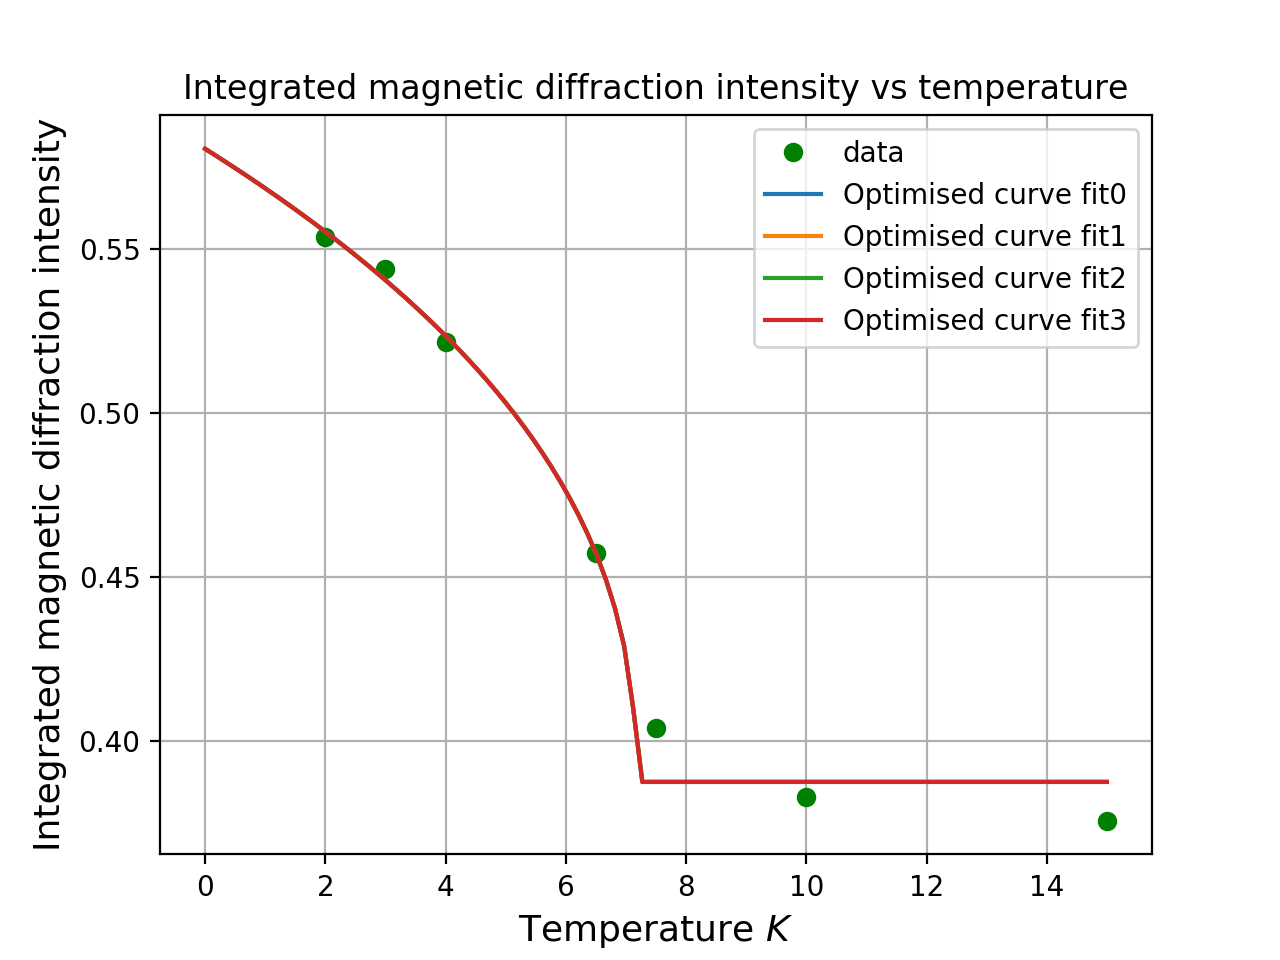

In [58]:
# Choose to delete the last point since we can see it makes the biggest effect.

data_without_lastpoint = scipy_paramater_finder(param_list,(float_temp[:-1],integrated_data[:-1]))

x1 = np.linspace(0,15,100)
figure()
ylabel("Integrated magnetic diffraction intensity",fontsize="13")
xlabel("Temperature $K$",fontsize="13")
title("Integrated magnetic diffraction intensity vs temperature")
grid()
plot(float_temp[:-1],integrated_data[:-1],"go",label="data")
count = -1
for i in data_without_lastpoint:
    count += 1
    plot(x1,M(x1,i),label="Optimised curve fit{}".format(count))
legend()
# Nothing happens just B value is higher and the straight line gets pushed up.

##### Understanding anti-ferromagtism:
Anti-ferromagtism is when in a material the magnetic moments align in a regular pattern opposing the neighbouring moments as shown below.
![Image of anti-ferromagtism](https://upload.wikimedia.org/wikipedia/commons/5/5d/Antiferromagnetic_ordering.svg)
When no external field is applied, the antiferromagnetic structure corresponds to a vanishing total magnetization. In an external magnetic field, a kind of behavior is displayed where even though the moments oppose each other the moments are unequal in size so in small regions there is a magnetic moment but overall there is no net magnitization in the material. Over a certain temperature anti-ferromagnetic properties dissapear as the thermal energy disrupts the order.

##### Understanding crystallographic unit cell size:
The smallest group of particles in the material that constitutes the repeating pattern is the unit cell of the structure. The unit cell completely defines the symmetry and structure of the entire crystal lattice, which is built up by repetitive translation of the unit cell along its principal axes.
![image of molecule](https://pubchem.ncbi.nlm.nih.gov/image/imagefly.cgi?cid=14801&width=200&height=200)
The reason why anti-ferromagnetic increases the magentic unit cell size is because even though with the image above the one molecule when translated will build the whole structure since one of the manganese molecules is 'up' and the other is 'down' to end where we began from another oxygen and manganese is needed to return to another 'up' manganese molecule.

##### Understanding the peaks in neutron diffraction:
The reason for the peaks in the diffraction is because when the temperature is above the critical temperature (neel's temperature) the the diffraction is solely caused by the neutrons hitting the nuclei themselves but when the temperature is below the critical temperature then the antiferromagnetic properties mean that the neutrons also experience scattering from the magnetic moments since they themselves posses a moment.

In [ ]:
# import nbformat
# def word_count(notebook):
#     """Prints the word count in Markdown cells of the file named notebook."""
#     with open(notebook, 'r', encoding='utf-8') as f:
#         nb = nbformat.read(f, as_version=4)
#     word_count = 0
#     total_word_count = 0
#     for cell in nb['cells']:
#         if cell['cell_type'] == "markdown":
#             lines = cell['source'].split('\n')
#             for line in lines:
#                 if len(line) > 0 and line[0] == '#':
#                     print(word_count)
#                     total_word_count += word_count
#                     word_count = 0
#                     print(line.strip(), end=" ==> ")
#                 else:
#                     word_count += len(line.lstrip().split(' '))
#     print(word_count)
#     print("Total ==> ", total_word_count)

# word_count('Project2-WriteUp.ipynb')

## Writing this up as a report (due Sunday 11 November)

Refer to the instructions on QM+. For this report I would like to see all sections: Introduction, Methods, Results, Discussion, and Conclusions. Think carefully about your results and explain them in a way that doesn't assume your reader is an expert in the science or the code.

As a start for your references, in addition to the paper on this material referenced above, you might like to refer to two very early reports of antiferromagnetic neutron diffraction in manganese oxide, MnO [[2](https://journals.aps.org/pr/pdf/10.1103/PhysRev.76.1256.2), [3](https://journals.aps.org/pr/pdf/10.1103/PhysRev.83.333)] These are complicated papers and difficult to read, so I recommend primarily looking at the figures. In the second, fuller paper, figures 4 and 6 show the magnetic diffraction peaks disappearing as the temperature is raised while figure 7 shows the intensity as a function of temperature. This should look similar to your own results!

I don't expect a lot of references, but it would be good to give a hint of the scientific context, and you may also want to refer, say, to the documentation for the Python functions you use.